<a href="https://colab.research.google.com/github/Vaycold/statistics_seminar/blob/main/covid19_tweet/simpleLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings 
import re

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer    
from google.colab import files

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split

from keras.models import Sequential, Model
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM, GlobalAveragePooling1D, Input
from keras.layers.embeddings import Embedding
from keras.layers.merge import Concatenate


warnings.filterwarnings('ignore')

os.environ['KAGGLE_USERNAME'] = 'kimgodbang'
os.environ['KAGGLE_KEY'] = '1c0e1716b23829d4381dcbced37ba49b'

!rm *.*
!kaggle competitions download -c sentiment-analysis-of-covid-19-related-tweets

train_df = pd.read_csv('training.csv')
test_df = pd.read_csv('validation.csv')

for module in ['stopwords', 'punkt', 'wordnet'] :
    nltk.download(module)

  0% 0.00/518k [00:00<?, ?B/s]
100% 518k/518k [00:00<00:00, 42.3MB/s]
  0% 0.00/254k [00:00<?, ?B/s]
100% 254k/254k [00:00<00:00, 81.7MB/s]
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
def labelsplit(labels) :
    
    label = labels.replace(' ',',').split(',')
    for idx, lab in enumerate(label) :
        label[idx] = int(lab)
    return label

In [5]:
train_df['label']  = train_df['Labels'].apply(lambda x :  labelsplit(x))

In [6]:
onehot = np.zeros((5000,11))
for i in range(5000) : # 0~5000 row
    for j in train_df.label[i] : # j = value   
        onehot[i,j]  = 1
cols_target = ['0','1','2','3','4','5','6','7','8','9','10']
onehot = pd.DataFrame(onehot, columns=cols_target)

In [7]:
train_df = pd.concat(
    [train_df, onehot], axis=1
).drop(['ID','Labels', 'label'],axis=1)

## EDA

 Tweet 중 단어가 가장 많은 tweet의 단어 수 : 30
 Tweet 중 단어가 가장 적은 tweet의 단어 수 : 1
 평균 tweet 의 길이 : 16.9214
 tweet 의 길이의 중간값 : 17.0




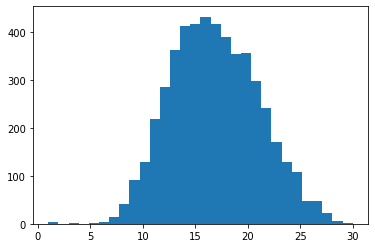

In [8]:
# 단어의 갯수

word_count = train_df['Tweet'].apply(lambda x : len(x.split(' ')))
print(f' Tweet 중 단어가 가장 많은 tweet의 단어 수 : {np.max(word_count)}')
print(f' Tweet 중 단어가 가장 적은 tweet의 단어 수 : {np.min(word_count)}')
print(f' 평균 tweet 의 길이 : {np.mean(word_count)}')
print(f' tweet 의 길이의 중간값 : {np.median(word_count)}')
print('\n')
plt.hist(word_count, bins=30)
plt.show()

## 텍스트 클렌징

In [9]:
stop = stopwords.words('english')
def word_lemmatizer(text):
    lem_text = [WordNetLemmatizer().lemmatize(i) for i in text]
    return lem_text
def  clean_text(df, text_field='Tweet', new_text_field_name='clean_tweet'):
    df[new_text_field_name] = df[text_field].str.lower()
    df[new_text_field_name] = df[new_text_field_name].apply(lambda x : x.lower())
    df[new_text_field_name] = df[new_text_field_name].apply(lambda x : x.replace('corona','covid'))
    df[new_text_field_name] = df[new_text_field_name].apply(lambda x : x.replace('coronavirus','virus'))
    df[new_text_field_name] = df[new_text_field_name].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))  
    df[new_text_field_name] = df[new_text_field_name].apply(lambda elem: re.sub(r"\d+", "", elem))
    df[new_text_field_name] = df[new_text_field_name].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
    df[new_text_field_name] = df[new_text_field_name].apply(lambda x: word_tokenize(x))
    df[new_text_field_name] = df[new_text_field_name].apply(lambda x: word_lemmatizer(x))
    df[new_text_field_name] = df[new_text_field_name].apply(lambda x: ' '.join(x))
    return df

In [10]:
def clean_df(df) :
    DF = clean_text(df, 'Tweet', 'clean_tweet')
    try :
        DF = DF[['clean_tweet','0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']]
        DF.columns = ['Tweet','0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
    except :
        DF = DF[['ID','clean_tweet']]
        DF.columns = ['ID','Tweet']
    
    return DF
    
def one(x) :
    if x > 2 :
        return 1
    else :
        return 0

In [11]:
train_df = clean_df(train_df)
test_df = clean_df(test_df)

In [12]:
train_df.head(2)

,Tweet,0,1,2,3,4,5,6,7,8,9,10
0,joke hop plane rn well covid lol,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,banmediahouse whose responsible spreading fake...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [13]:
test_df.head(2)

,ID,Tweet
0,5001,forgot math test failing teacher opening back ...
1,5002,covid effected came delhi bihar lakhisarai dis...


In [14]:
# 단어수 
print(len(set([word for words in train_tweet for word in words.split()])))

NameError: ignored

In [ ]:
word_count = train_df['Tweet'].apply(lambda x : len(x.split(' ')))
print(f' Tweet 중 단어가 가장 많은 tweet의 단어 수 : {np.max(word_count)}')
print(f' Tweet 중 단어가 가장 적은 tweet의 단어 수 : {np.min(word_count)}')
print(f' 평균 tweet 의 길이 : {np.mean(word_count)}')
print(f' tweet 의 길이의 중간값 : {np.median(word_count)}')
print('\n')
plt.hist(word_count, bins=20)
plt.show()

In [15]:
np.quantile(word_count, 0.025)

9.0

 Tweet 중 단어가 가장 많은 tweet의 단어 수 : 20
 Tweet 중 단어가 가장 적은 tweet의 단어 수 : 1
 평균 tweet 의 길이 : 10.1968
 tweet 의 길이의 중간값 : 10.0




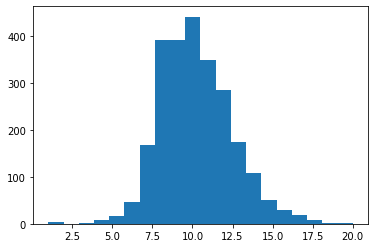

In [16]:
word_count = test_df['Tweet'].apply(lambda x : len(x.split(' ')))
print(f' Tweet 중 단어가 가장 많은 tweet의 단어 수 : {np.max(word_count)}')
print(f' Tweet 중 단어가 가장 적은 tweet의 단어 수 : {np.min(word_count)}')
print(f' 평균 tweet 의 길이 : {np.mean(word_count)}')
print(f' tweet 의 길이의 중간값 : {np.median(word_count)}')
print('\n')
plt.hist(word_count, bins=20)
plt.show()

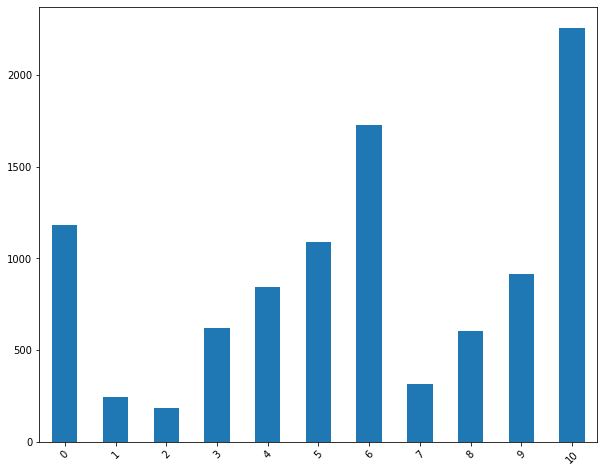

In [17]:
train_df_sentiment = train_df[cols_target]
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

train_df_sentiment.sum(axis=0).plot.bar()
plt.xticks(rotation = 45)
plt.show()

## 토큰화 및 패딩

In [ ]:
train_tweet = train_df['Tweet'].values
test_tweet = test_df['Tweet'].values

In [ ]:
train_tweet[:2]

array(['joke hop plane rn well covid lol',
       'banmediahouse whose responsible spreading fake communal story pandemic covid situation'],
      dtype=object)

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_tweet)

train_token = tokenizer.texts_to_sequences(train_tweet)
train_token[0]

[8, 1838, 2382, 357, 96, 1, 133]

In [ ]:
print(train_tweet[0])
print(train_token[0])

joke hop plane rn well covid lol
[8, 1838, 2382, 357, 96, 1, 133]


In [ ]:
word_vocab = tokenizer.word_index
#print(word_vocab)

In [ ]:
print(f'단어 전체의 갯수 {len(word_vocab)}')

단어 전체의 갯수 8517


In [ ]:
maxlen = 21 # 전처리 후 최댓값
train_pad = pad_sequences(train_token, maxlen = maxlen, padding = 'pre')
print(train_tweet[0])
print(train_token[0])
print(train_pad[0])

joke hop plane rn well covid lol
[8, 1838, 2382, 357, 96, 1, 133]
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    8 1838 2382  357   96    1  133]


In [ ]:
print(type(train_pad))
print(train_pad.shape)
print(train_pad[0].shape)

<class 'numpy.ndarray'>
(5000, 21)
(21,)


## 벡터화


### SENTENCEPIECE

In [ ]:
!pip install sentencepiece
import sentencepiece as spm

     |████████████████████████████████| 1.2MB 12.6MB/s 


In [ ]:
train_tweet.shape

(5000,)

In [ ]:
with open('./full_tweet.txt', 'w', encoding='utf-8') as f:
    for line in train_tweet :
        if len(str(line).strip()) == 0 : continue
        try : 
            f.write(line + '\n')
        except : continue

In [ ]:
!cat full_tweet.txt | head -n2

joke hop plane rn well covid lol
banmediahouse whose responsible spreading fake communal story pandemic covid situation


In [ ]:
spm.SentencePieceTrainer.train('--input=full_tweet.txt --model_prefix=m --vocab_size=5000')

In [ ]:
sp = spm.SentencePieceProcessor()
sp.load('m.model')

True

In [ ]:
train_df['bow'] = train_df['Tweet'].apply(lambda x : sp.encode_as_ids(str(x)))
test_df['bow'] = test_df['Tweet'].apply(lambda x : sp.encode_as_ids(str(x)))

In [ ]:
train_df.head(2)

,Tweet,0,1,2,3,4,5,6,7,8,9,10,bow
0,joke hop plane rn well covid lol,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,"[22, 369, 2018, 542, 164, 3, 222]"
1,banmediahouse whose responsible spreading fake...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,"[1055, 2401, 2059, 148, 458, 1402, 58, 98, 4, ..."


In [ ]:
test_df.head(2)

,ID,Tweet,bow
0,5001,forgot math test failing teacher opening back ...,"[1465, 4023, 42, 828, 4, 5, 1353, 412, 4, 85, ..."
1,5002,covid effected came delhi bihar lakhisarai dis...,"[3, 2761, 7, 379, 718, 2801, 233, 1929, 1562, ..."


In [ ]:
train_pad = pad_sequences(train_df['bow'].values, maxlen=22)
test_pad = pad_sequences(test_df['bow'].values, maxlen=22)

## 여기부터 볼 것

In [18]:
train_df.head()

,Tweet,0,1,2,3,4,5,6,7,8,9,10
0,joke hop plane rn well covid lol,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,banmediahouse whose responsible spreading fake...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,im waiting someone say covid thing april fool ...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,liar proven day night time lie truth covid,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,new u covidvirus death toll reach nearly new d...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [19]:
test_df.head()

,ID,Tweet
0,5001,forgot math test failing teacher opening back ...
1,5002,covid effected came delhi bihar lakhisarai dis...
2,5003,make covid end na
3,5004,imagine covidvirus pandemic big april fool jok...
4,5005,howdy ana get married covidvirus update gov


In [28]:
all_tweet = pd.concat(
    [train_df['Tweet'], test_df['Tweet']] , axis=0
)
all_tweet = all_tweet.reset_index()['Tweet']

In [37]:
all_tweet.values.tolist()[:2]

['joke hop plane rn well covid lol',
 'banmediahouse whose responsible spreading fake communal story pandemic covid situation']

In [38]:
all_texts = all_tweet.values.tolist()

In [39]:
x = train_df.Tweet.values.tolist()
#y = train_df_sentiment.values

In [42]:
x[:2]

['joke hop plane rn well covid lol',
 'banmediahouse whose responsible spreading fake communal story pandemic covid situation']

In [43]:
y[:2]

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]])

In [45]:
#x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.2, random_state =42)
tokenizer = Tokenizer(num_words = 10000)
tokenizer.fit_on_texts(x)

x_train = tokenizer.texts_to_sequences(x)
vocab_size = len(tokenizer.word_index) + 1
maxlen = 30
x_train = pad_sequences(x_train, maxlen = maxlen)

(5000, 30)

In [47]:
#glove

!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

--2021-06-07 07:38:24--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-06-07 07:38:24--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-06-07 07:38:24--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [48]:
f = open('glove.6B.100d.txt', encoding="utf8")
embeddings_dictionary = dict()
for line in f:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions

f.close()

In [49]:
embedding_matrix = np.zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [50]:
embedding_matrix.shape

(8518, 100)

In [51]:
x_train.shape

(5000, 30)

In [52]:
from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [53]:
inputs = Input(shape=(maxlen,))
embedding = Embedding(vocab_size, 100, weights = [embedding_matrix], trainable=False)(inputs)
input_x = LSTM(128)(embedding)
outputs = Dense(11, activation = 'sigmoid')(input_x)

model = Model(inputs, outputs)
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics=[f1])

In [54]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 30, 100)           851800    
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense (Dense)                (None, 11)                1419      
Total params: 970,467
Trainable params: 118,667
Non-trainable params: 851,800
_________________________________________________________________


In [73]:
y_train = train_df[cols_target].values

In [76]:
x_train.shape, y_train.shape

((5000, 30), (5000, 11))

In [77]:
model.fit(x_train, y_train, epochs=5, verbose = 1, validation_split = 0.2)

Epoch 1/5
125/125 [==============================] - 24s 42ms/step - loss: 0.4751 - f1: 0.1573 - val_loss: 0.3937 - val_f1: 0.2526
Epoch 2/5
125/125 [==============================] - 4s 35ms/step - loss: 0.3898 - f1: 0.2920 - val_loss: 0.3849 - val_f1: 0.2439
Epoch 3/5
125/125 [==============================] - 4s 35ms/step - loss: 0.3744 - f1: 0.3366 - val_loss: 0.3744 - val_f1: 0.3858
Epoch 4/5
125/125 [==============================] - 4s 35ms/step - loss: 0.3601 - f1: 0.4075 - val_loss: 0.3716 - val_f1: 0.3807
Epoch 5/5
125/125 [==============================] - 4s 35ms/step - loss: 0.3513 - f1: 0.4228 - val_loss: 0.3707 - val_f1: 0.4054


In [80]:
x_tweet = test_df.Tweet.values.tolist()
x_test =tokenizer.texts_to_sequences(x_tweet)
x_test = pad_sequences(x_test, maxlen= maxlen)
x_test.shape

(2500, 30)

In [255]:
res = model.predict(x_test)
res.shape

(2500, 11)

In [256]:
for row in range(2500) :
    
    if max(res[row].tolist()) <= 0.5 :
        idx = res[row].tolist().index(max(res[row].tolist()))
        res[row][idx] = 1 # 결측값 = 확률가장높은 idx에 1 부여
res = res > 0.5
res = pd.DataFrame(res)
res = res.applymap(lambda x : 1 if x else 0)
res[:10]

,0,1,2,3,4,5,6,7,8,9,10
0,0,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,1
5,0,0,0,0,0,0,1,0,0,0,0
6,0,0,0,0,0,0,1,0,0,0,0
7,0,0,0,0,0,0,1,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,1
9,0,0,0,0,0,0,0,0,0,0,1


In [261]:
res[res.sum(axis=1) == 0]
# 결측값 없음.

,0,1,2,3,4,5,6,7,8,9,10


In [263]:
res.sum(axis=0)

0      381
1        8
2       33
3        2
4       73
5      198
6      845
7        7
8      231
9       15
10    1093
dtype: int64

In [267]:
test_df.head()

,ID,Tweet
0,5001,forgot math test failing teacher opening back ...
1,5002,covid effected came delhi bihar lakhisarai dis...
2,5003,make covid end na
3,5004,imagine covidvirus pandemic big april fool jok...
4,5005,howdy ana get married covidvirus update gov


In [269]:
submission = test_df.drop(['Tweet'], axis=1)
submission['Labels'] = None
submission.head()

,ID,Labels
0,5001,None
1,5002,None
2,5003,None
3,5004,None
4,5005,None


In [271]:
Res = np.array(res)
Res[0]

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

In [273]:
for i in range(2500) :
        one_row = []
        for cat in cols_target :
            if int(res[i:i+1][int(cat)].values) == 1 :
                one_row.append(str(cat))
        submission['Labels'][i] = ' '.join(one_row)

In [280]:
submission[140:150]

,ID,Labels
140,5141,2
141,5142,10
142,5143,6
143,5144,6 10
144,5145,8
145,5146,10
146,5147,6 10
147,5148,10
148,5149,6
149,5150,6


In [281]:
submission.to_csv('simpleLSTM.csv', index=False)
from google.colab import files
files.download('simpleLSTM.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>